# Meta-analytic functional decoding
## Discrete functional decoding


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nimare
import nibabel as nib
from nilearn import datasets
from nimare.stats import pearson
from nimare.dataset import Dataset
from nimare.decode import discrete
from nimare.utils import get_resource_path
from nimare.extract import fetch_neurosynth
from nimare.io import convert_neurosynth_to_dataset
from nimare.decode import continuous
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.image import load_img
from nilearn.image import new_img_like
from nilearn import datasets, plotting
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
from nibabel import Nifti1Image


## Create a region of interest
### 创建球形ROI

根据疾病组和健康组元分析结果，创建相关的ROI

疾病组： 创建一个brain mask：
- Frontal pole （-6，58，18）

健康组： 创建五个brain mask
- Paracingulate Gyrus （0，48，8）
- Frontal Orbital Cortex （-38，24，-14）
- Cingulate Gyrus posterior division （-2，-54，26）
- Angular Gyrus （-44, -58，24）
- Frontal Orbital Cortex （32， 18, -18）

参考的neurostars 链接

> https://neurostars.org/t/how-to-interpret-results-of-nimare-decode-discrete-roiassociationdecoder/30190

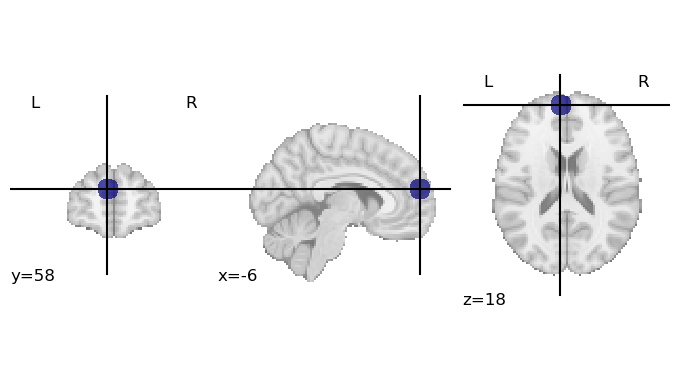

In [5]:
# let's assume we are in MNI space
brain_mask = datasets.load_mni152_brain_mask()

# generate a mask for the left FPole
_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=[(-6, 58, 18)], 
    niimg=None,
    radius=10,
    allow_overlap=False, 
    mask_img=brain_mask)

# Unmask the result (converts the sparse matrix to a 3D array)
# _unmask_3d will convert the masked array into the shape of the original brain mask
FPole_mask = _unmask_3d(
    X=A.toarray().flatten(), 
    mask=brain_mask.get_fdata().astype(bool))

FPole_roi = Nifti1Image(FPole_mask, brain_mask.affine)

# save the roi
nib.save(FPole_roi, "../data/decoding_roi/FPole.nii.gz")

# plot the result to make sure it makes sense
plotting.plot_roi("../data/decoding_roi/FPole.nii.gz")

In [9]:
# get neurosynth data
databases = nimare.extract.fetch_neurosynth(data_dir='../data')[0]

# convert to NiMARE dataset (Note: This can take a while!)
ds = nimare.io.convert_neurosynth_to_dataset(
    coordinates_file=databases['coordinates'],
    metadata_file=databases['metadata'],
    annotations_files=databases['features']
    )

INFO:nimare.extract.utils:Dataset found in ../data/neurosynth

INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('data-neurosynth', 'version-7')]


File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.


In [14]:
# decode ROI image
# See: https://nimare.readthedocs.io/en/latest/decoding.html#discrete-decoding

from nimare import decode
FPole_decoder = decode.discrete.ROIAssociationDecoder(
    FPole_roi,
    frequency_threshold=0.001,
    u=0.05,
    correction="fdr_bh",
)

In [15]:
# Fit the decoder to the dataset
FPole_decoder.fit(ds)

In [16]:
FPole_ds = FPole_decoder.transform()

In [19]:
FPole_ds.to_csv('../results/decoding/FPole_decode.csv', index=True)

## Controls：Meta-analytic decoding

健康组： 创建5个brain mask
- Paracingulate Gyrus （0，48，8）
- Frontal Orbital Cortex （-38，24，-14）
- Cingulate Gyrus posterior division （-2，-54，26）
- Angular Gyrus （-44, -58，24）
- Frontal Orbital Cortex （32， 18, -18）

In [29]:
# generate a mask for the left FPole
_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=[(0, 48, 8)], 
    niimg=None,
    radius=10,
    allow_overlap=False, 
    mask_img=brain_mask)

# Unmask the result (converts the sparse matrix to a 3D array)
# _unmask_3d will convert the masked array into the shape of the original brain mask
PCG_mask = _unmask_3d(
    X=A.toarray().flatten(), 
    mask=brain_mask.get_fdata().astype(bool))

PCG_roi = Nifti1Image(PCG_mask, brain_mask.affine)

In [24]:

_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=[(-38, 24, -14)], 
    niimg=None,
    radius=10,
    allow_overlap=False, 
    mask_img=brain_mask)

L_FOC_mask = _unmask_3d(
    X=A.toarray().flatten(), 
    mask=brain_mask.get_fdata().astype(bool))

L_FOC_roi = Nifti1Image(L_FOC_mask, brain_mask.affine)

In [25]:
_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=[(-2, -54, 26)], 
    niimg=None,
    radius=10,
    allow_overlap=False, 
    mask_img=brain_mask)

Cingulate_mask = _unmask_3d(
    X=A.toarray().flatten(), 
    mask=brain_mask.get_fdata().astype(bool))

Cingulate_roi = Nifti1Image(Cingulate_mask, brain_mask.affine)

In [26]:
_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=[(-44, -58, 24)], 
    niimg=None,
    radius=10,
    allow_overlap=False, 
    mask_img=brain_mask)

Angular_mask = _unmask_3d(
    X=A.toarray().flatten(), 
    mask=brain_mask.get_fdata().astype(bool))

Angular_roi = Nifti1Image(Angular_mask, brain_mask.affine)

In [27]:
_, A = nifti_spheres_masker._apply_mask_and_get_affinity(
    seeds=[(32, 18, -18)], 
    niimg=None,
    radius=10,
    allow_overlap=False, 
    mask_img=brain_mask)

R_FOC_mask = _unmask_3d(
    X=A.toarray().flatten(), 
    mask=brain_mask.get_fdata().astype(bool))

R_FOC_roi = Nifti1Image(R_FOC_mask, brain_mask.affine)

In [38]:
# save the roi
nib.save(PCG_roi, "../data/decoding_roi/PCG.nii.gz")
nib.save(L_FOC_roi, "../data/decoding_roi/L_FOC_roi.nii.gz")
nib.save(Cingulate_roi, "../data/decoding_roi/Cingulate_roi.nii.gz")
nib.save(Angular_roi, "../data/decoding_roi/Angular_roi.nii.gz")
nib.save(R_FOC_roi, "../data/decoding_roi/R_FOC_roi.nii.gz")

### Controls：decoding

In [39]:
roi_files = {
    "PCG": "../data/decoding_roi/PCG.nii.gz",
    "L_FOC": "../data/decoding_roi/L_FOC_roi.nii.gz",
    "Cingulate": "../data/decoding_roi/Cingulate_roi.nii.gz",
    "Angular": "../data/decoding_roi/Angular_roi.nii.gz",
    "R_FOC": "../data/decoding_roi/R_FOC_roi.nii.gz"
}

In [36]:
# define decoder parameters
frequency_threshold = 0.001
u = 0.05
correction = "fdr_bh"

In [41]:
# decode ROI image

for roi_name, roi_path in roi_files.items():
    # load ROI image
    roi_img = nib.load(roi_path)
    
    # generate decoder
    decoder = decode.discrete.ROIAssociationDecoder(
        roi_img,
        frequency_threshold=frequency_threshold,
        u=u,
        correction=correction,
    )
    
    # fit decoder to dataset
    decoder.fit(ds)
    
    # decoding and save to csv
    decoded_ds = decoder.transform()
    output_csv_path = f'../results/decoding/{roi_name}_decode.csv'
    decoded_ds.to_csv(output_csv_path, index=True)

    print(f"Decoding for {roi_name} completed and saved to {output_csv_path}")

Decoding for PCG completed and saved to ../results/decoding/PCG_decode.csv
Decoding for L_FOC completed and saved to ../results/decoding/L_FOC_decode.csv
Decoding for Cingulate completed and saved to ../results/decoding/Cingulate_decode.csv
Decoding for Angular completed and saved to ../results/decoding/Angular_decode.csv
Decoding for R_FOC completed and saved to ../results/decoding/R_FOC_decode.csv


### Extract decoding CSV files based on Table S1 from Poldrack's paper


> **Source**：Poldrack, R. A., Mumford, J. A., Schonberg, T., Kalar, D., Barman, B., & Yarkoni, T. (2012). Discovering Relations Between Mind, Brain, and Mental Disorders Using Topic Mapping. PLOS Computational Biology, 8(10), e1002707. https://doi.org/10.1371/journal.pcbi.1002707

> **Description**：Complete list of topics identified through application of latent Dirichlet allocation to the text corpus filtered for Cognitive Atlas terms. The top 5 words shown for each topic are those which had the highest loading for that topic across documents. The number of documents that loaded on each topic is also listed.

In [9]:
# 1. 读取txt文件，获取所有的单词，去掉换行符和空格，并替换下划线
with open('../data/tableS1.txt', 'r') as file:
    words = [word.strip().replace('_', ' ') for line in file for word in line.split(',')]

# 2. 将处理后的单词列表保存到一个新txt文件
with open('../data/tableS1_re.txt', 'w') as new_file:
    # 将每个单词按行写入新文件
    for word in words:
        new_file.write(word + '\n')


In [11]:
import pandas as pd
import os

# 假设您有多个 CSV 文件存放在一个文件夹中
input_folder = '../results/decoding'  # 修改为存放 CSV 文件的文件夹路径
output_folder = '../results/decoding_re'  # 修改为保存处理后的文件的文件夹路径

# 确保输出文件夹存在
os.makedirs(output_folder, exist_ok=True)

In [12]:
# 遍历文件夹中的所有 CSV 文件
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):  # 仅处理 CSV 文件
        input_path = os.path.join(input_folder, file_name)
        
        # 读取 CSV 文件
        df = pd.read_csv(input_path)
        
        # 筛选以 "terms_abstract_tfidf__" 开头的行
        filtered_df = df[df['feature'].str.startswith('terms_abstract_tfidf__', na=False)]
        
        # 保存处理后的文件到输出文件夹
        output_path = os.path.join(output_folder, file_name)
        filtered_df.to_csv(output_path, index=False)
        print(f'已处理文件: {file_name} 并保存到 {output_path}')


已处理文件: R_FOC_decode.csv 并保存到 ../results/decoding_re/R_FOC_decode.csv
已处理文件: Cingulate_decode.csv 并保存到 ../results/decoding_re/Cingulate_decode.csv
已处理文件: Angular_decode.csv 并保存到 ../results/decoding_re/Angular_decode.csv
已处理文件: FPole_decode.csv 并保存到 ../results/decoding_re/FPole_decode.csv
已处理文件: PCG_decode.csv 并保存到 ../results/decoding_re/PCG_decode.csv
已处理文件: L_FOC_decode.csv 并保存到 ../results/decoding_re/L_FOC_decode.csv


In [18]:
# 读取 txt 文件中的词
with open('../data/tableS1_re.txt', 'r', encoding='utf-8') as f:
    words = [line.strip() for line in f.readlines()]

# 读取 CSV 文件
data = pd.read_csv('../results/decoding_re/Angular_decode.csv')

# 提取 feature 列中以 terms_abstract_tfidf__ 开头的部分，并删除前缀
pattern = re.compile(r'terms_abstract_tfidf__(.+)')

# 定义一个函数，提取 xxx 部分
def extract_xxx(feature):
    match = pattern.match(feature)
    return match.group(1) if match else None

# 在 feature 列中提取 xxx 部分
data['xxx'] = data['feature'].apply(extract_xxx)

# 筛选出 xxx 列中包含 txt 文件中词的行
filtered_data = data[data['xxx'].str.contains('|'.join(words), case=False, na=False)]

# 删除 feature 列，保留 xxx 列
filtered_data = filtered_data[['xxx', 'r']]

# 保存结果为新的 CSV 文件
filtered_data.to_csv('../results/extract_decoding/extract_Angular_decode.csv', index=False)

print("筛选后的数据已保存为 'extract_Angular_decode.csv'")


筛选后的数据已保存为 'extract_Angular_decode.csv'


In [19]:
import pandas as pd
import re
import os

# 读取 txt 文件中的词
with open('../data/tableS1_re.txt', 'r', encoding='utf-8') as f:
    words = [line.strip() for line in f.readlines()]

# 定义一个正则表达式模式，用于匹配以 "terms_abstract_tfidf__" 开头的部分
pattern = re.compile(r'terms_abstract_tfidf__(.+)')

# 定义一个函数，提取 `xxx` 部分
def extract_xxx(feature):
    match = pattern.match(feature)
    return match.group(1) if match else feature  # 如果无法匹配，保留原值

# 定义要处理的 CSV 文件路径列表
csv_files = [
    '../results/decoding_re/Angular_decode.csv',
    '../results/decoding_re/Cingulate_decode.csv',
    '../results/decoding_re/FPole_decode.csv',
    '../results/decoding_re/PCG_decode.csv',
    '../results/decoding_re/L_FOC_decode.csv',
    '../results/decoding_re/R_FOC_decode.csv'
]

# 批量处理 CSV 文件
for csv_file in csv_files:
    # 读取 CSV 文件
    data = pd.read_csv(csv_file)

    # 确保 `feature` 列中提取的部分完全保留原始内容
    data['cognitive_feature'] = data['feature'].apply(extract_xxx)

    # 筛选出 cognitive_feature 列中包含 txt 文件中词的行
    filtered_data = data[data['cognitive_feature'].str.contains('|'.join(words), case=False, na=False)]

    # 删除 feature 列，保留 cognitive_feature 列和 r 列
    filtered_data = filtered_data[['cognitive_feature', 'r']]

    # 保存结果为新的 CSV 文件
    output_file = os.path.join('../results/extract_decoding', f'extract_{os.path.basename(csv_file)}')
    filtered_data.to_csv(output_file, index=False)

    print(f"筛选后的数据已保存为 '{output_file}'")


筛选后的数据已保存为 '../results/extract_decoding/extract_Angular_decode.csv'
筛选后的数据已保存为 '../results/extract_decoding/extract_Cingulate_decode.csv'
筛选后的数据已保存为 '../results/extract_decoding/extract_FPole_decode.csv'
筛选后的数据已保存为 '../results/extract_decoding/extract_PCG_decode.csv'
筛选后的数据已保存为 '../results/extract_decoding/extract_L_FOC_decode.csv'
筛选后的数据已保存为 '../results/extract_decoding/extract_R_FOC_decode.csv'


### Plot word cloud

In [8]:
from wordcloud import WordCloud
import matplotlib

# 定义输入文件列表
csv_files = [
    '../results/extract_decoding/extract_Angular_decode.csv',
    '../results/extract_decoding/extract_Cingulate_decode.csv',
    '../results/extract_decoding/extract_FPole_decode.csv',
    '../results/extract_decoding/extract_L_FOC_decode.csv',
    '../results/extract_decoding/extract_R_FOC_decode.csv',
    '../results/extract_decoding/extract_PCG_decode.csv'
]

# 定义输出目录
output_dir = '../results/wordcloud'
os.makedirs(output_dir, exist_ok=True)  # 如果目录不存在，则创建


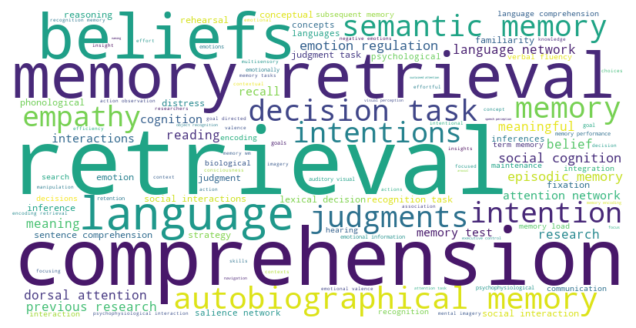

词云图已保存到 ../results/wordcloud/Angular_wordcloud.png


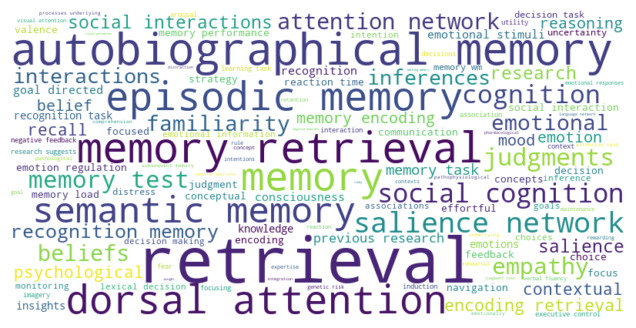

词云图已保存到 ../results/wordcloud/Cingulate_wordcloud.png


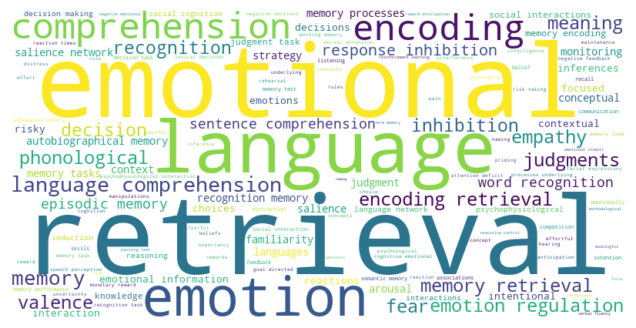

词云图已保存到 ../results/wordcloud/L_FOC_wordcloud.png


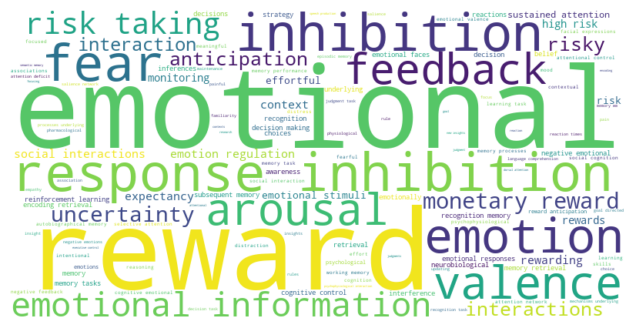

词云图已保存到 ../results/wordcloud/R_FOC_wordcloud.png


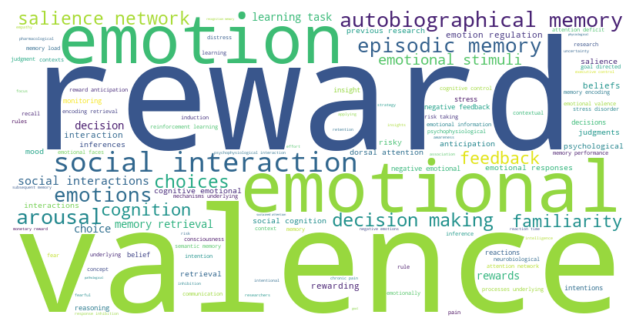

词云图已保存到 ../results/wordcloud/PCG_wordcloud.png


In [30]:
# 批量处理每个 CSV 文件
for file_path in csv_files:
    # 读取 CSV 数据
    data = pd.read_csv(file_path)

    # 构建词频字典，使用 'cognitive_feature' 作为单词，'r' 作为词频
    word_frequencies = data.set_index('cognitive_feature')['r'].to_dict()

    # 创建词云
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        prefer_horizontal=1.0
    ).generate_from_frequencies(word_frequencies)

    # 绘制并显示词云图
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # 关闭坐标轴
    plt.show()

    # 保存词云图为文件
    file_name = os.path.basename(file_path).replace('extract_', '').replace('_decode.csv', '')  # 提取文件名的一部分
    output_path = os.path.join(output_dir, f'{file_name}_wordcloud.png')
    wordcloud.to_file(output_path)

    print(f"词云图已保存到 {output_path}")
